In [2]:
"""
필요한 모듈 및 프레임워크를 잘 생각하고 넣자
"""
from keras.utils import np_utils
from keras.callbacks import ModelCheckpoint, EarlyStopping
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras import layers
from PIL import Image
from keras.preprocessing.image import img_to_array
import tensorflow as tf
import numpy as np
import pandas as pd 
import os, re

In [6]:
"""
전처리 후 npy파일로 저장하기위한 코드
일단 사이즈는 강제로 256,256으로 변환시키는 방식
각 이미지를 일차원 배열로 생성
사용시에는 인덱스에 맞게 꺼내서 사용할 예정
"""

current_path = os.path.abspath('')
input_img_path = os.path.join(current_path,"input_img")
target_img_path = os.path.join(current_path,"target_img")
input_files = os.listdir(input_img_path)
target_files = os.listdir(target_img_path)
datasets = []
i = 0
test_data = np.array([])
for input_file, target_file in zip(input_files, target_files):
    dataset= []
    plus_input = []
    mul_input = []
    input_pro = []
    name = str(input_file)
    #레이놀즈 수 파일 이름에서 추출
    R = float(name[5]+"."+name[6]+name[7])*10**int(name[8])/(1.3*(10**6))
    #인풋 이미지 파일 경로로 들어가서 인풋 이미지 전처리 과정
    os.chdir(input_img_path)
    input_img = Image.open(input_file)
    #이미지 리사이징
    input_img = input_img.resize((256, 256))
    #이미지 nunpy배열로 변환
    input_img_tensor = img_to_array(input_img)
    input_img_tensor = input_img_tensor.reshape(196608).astype('float64')/ 255
    #타겟 이미지 파일 경로로 들어가서 전처리 과정
    os.chdir(target_img_path)
    target_img = Image.open(target_file)
    target_img = target_img.resize((256,256))
    #타겟 이미지는 1차원 배열로 생성
    target_img_tensor = img_to_array(target_img)
    target_img_tensor = target_img_tensor.reshape(196608).astype('float64')/ 255
    plus_input = (input_img_tensor +R)/2
    dataset = np.concatenate((input_img_tensor,plus_input), axis = 0)
    dataset = np.concatenate((dataset,target_img_tensor), axis = 0)
    datasets.insert(i,dataset)
    i += 1
    os.chdir('..')
datasets = np.array(datasets)
#[:,:196608]인풋 이미지,[:,196608:393216]레이놀즈수,[:,393216:]타겟 이미지
np.save("test.npy", datasets)
print(datasets.shape)

(1169, 589824)


In [4]:

dataset = np.load('test.npy', allow_pickle=True)
X = dataset[:,196608:393216]
Y = dataset[:,393216:]
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state =1)
X_test, X_val,Y_test, Y_val = train_test_split(X_test,Y_test,test_size=0.5,random_state=1)
X_train = X_train.reshape(X_train.shape[0], 256,256,3)
X_test = X_test.reshape(X_test.shape[0], 256,256,3)
X_val = X_val.reshape(X_val.shape[0], 256,256,3)
Y_train = Y_train.reshape(Y_train.shape[0], 256,256,3)
Y_test = Y_test.reshape(Y_test.shape[0], 256,256,3)
Y_val = Y_val.reshape(Y_val.shape[0], 256,256,3)


In [5]:
"""
VGG16과 u-net의 조합을 해볼 생각이다.
"""
input_e = tf.keras.Input(shape=(256,256,3))

block1_conv1 = layers.Conv2D(64, 3, activation='relu', padding = 'same')(input_e)
block1_conv2 = layers.Conv2D(64, 3, activation='relu', padding = 'same')(block1_conv1)
block1_pool = layers.MaxPooling2D(2)(block1_conv2)
        
block2_conv1 = layers.Conv2D(128, 3, activation='relu', padding = 'same')(block1_pool)
block2_conv2 = layers.Conv2D(128, 3, activation='relu', padding = 'same')(block2_conv1)
block2_pool = layers.MaxPooling2D(2)(block2_conv2)

block3_conv1 = layers.Conv2D(256, 3, activation='relu', padding = 'same')(block2_pool)
block3_conv2 = layers.Conv2D(256, 3, activation='relu', padding = 'same')(block3_conv1)
block3_conv3 = layers.Conv2D(256, 3, activation='relu', padding = 'same')(block3_conv2)
block3_pool = layers.MaxPooling2D(2)(block3_conv3)

block4_conv1 = layers.Conv2D(512, 3, activation='relu', padding = 'same')(block3_pool)
block4_conv2 = layers.Conv2D(512, 3, activation='relu', padding = 'same')(block4_conv1)
block4_conv3 = layers.Conv2D(512, 3, activation='relu', padding = 'same')(block4_conv2)
block4_pool = layers.MaxPooling2D(2)(block4_conv3)

block5_conv1 = layers.Conv2D(512, 3, activation='relu', padding = 'same')(block4_pool)
block5_conv2 = layers.Conv2D(512, 3, activation='relu', padding = 'same')(block5_conv1)
block5_conv3 = layers.Conv2D(512, 3, activation='relu', padding = 'same')(block5_conv2)
block5_pool = layers.MaxPooling2D(2)(block5_conv3)
"""
여기까지가 VGG16을 구현한 장소
"""
block6_convt1 = layers.Conv2DTranspose(512, 3, activation='relu', padding='same')(block5_pool)
block6_upsamp = layers.UpSampling2D(2)(block6_convt1)
block6_skipcon = layers.Concatenate(axis=3)([block4_pool, block6_upsamp])
block6_convt2 = layers.Conv2D(512, 3, activation = 'relu', padding='same')(block6_skipcon)

block7_convt1 = layers.Conv2DTranspose(256, 3, activation='relu', padding='same')(block6_convt2)
block7_upsamp = layers.UpSampling2D(2)(block7_convt1)
block7_skipcon = layers.Concatenate(axis=3)([block3_pool, block7_upsamp])
block7_convt2 = layers.Conv2D(256, 3, activation = 'relu', padding='same')(block7_skipcon)

block8_convt1 = layers.Conv2DTranspose(128, 3, activation='relu', padding='same')(block7_convt2)
block8_upsamp = layers.UpSampling2D(2)(block8_convt1)
block8_skipcon = layers.Concatenate(axis=3)([block2_pool, block8_upsamp])
block8_convt2 = layers.Conv2D(128, 3, activation = 'relu', padding='same')(block8_skipcon)

block9_convt1 = layers.Conv2DTranspose(64, 3, activation='relu', padding='same')(block8_convt2)
block9_upsamp = layers.UpSampling2D(2)(block9_convt1)
block9_skipcon = layers.Concatenate(axis=3)([block1_pool, block9_upsamp])
block9_convt2 = layers.Conv2D(64, 3, activation = 'relu', padding='same')(block9_skipcon)

block10_convt1 = layers.Conv2DTranspose(64, 3, activation='relu', padding='same')(block9_convt2)
block10_upsamp = layers.UpSampling2D(2)(block10_convt1)

output_d = layers.Conv2DTranspose(3, 3, activation='relu', padding='same')(block10_upsamp)

model = keras.Model(input_e, output_d, name = 'unet-VGG16')

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0012, decay = 0.013),loss='mse', metrics=['mae'])
history = model.fit(X_train,Y_train,epochs=500, validation_data=(X_val, Y_val), batch_size=10)

#hist = model.fit(X_tr,Y_tr['M'],epochs=500, validation_data=(X_vid, Y_vid['M']), batch_size=32)

model.summary()
model.save('test_model_unet_VGG.h5')

Epoch 1/500
94/94 [==============================] - 25s 214ms/step - loss: 0.0832 - mae: 0.1573 - val_loss: 0.0314 - val_mae: 0.0969
Epoch 2/500
94/94 [==============================] - 16s 174ms/step - loss: 0.0311 - mae: 0.0885 - val_loss: 0.0230 - val_mae: 0.0667
Epoch 3/500
94/94 [==============================] - 16s 168ms/step - loss: 0.0265 - mae: 0.0769 - val_loss: 0.0230 - val_mae: 0.0720
Epoch 4/500
94/94 [==============================] - 16s 169ms/step - loss: 0.0255 - mae: 0.0749 - val_loss: 0.0209 - val_mae: 0.0620
Epoch 5/500
94/94 [==============================] - 16s 169ms/step - loss: 0.0244 - mae: 0.0719 - val_loss: 0.0206 - val_mae: 0.0629
Epoch 6/500
94/94 [==============================] - 16s 169ms/step - loss: 0.0239 - mae: 0.0705 - val_loss: 0.0202 - val_mae: 0.0615
Epoch 7/500
94/94 [==============================] - 16s 171ms/step - loss: 0.0233 - mae: 0.0688 - val_loss: 0.0199 - val_mae: 0.0603
Epoch 8/500
94/94 [==============================] - 17s 184ms

94/94 [==============================] - 15s 161ms/step - loss: 9.9949e-04 - mae: 0.0131 - val_loss: 7.5037e-04 - val_mae: 0.0126
Epoch 62/500
94/94 [==============================] - 15s 161ms/step - loss: 9.7812e-04 - mae: 0.0129 - val_loss: 6.8642e-04 - val_mae: 0.0119
Epoch 63/500
94/94 [==============================] - 15s 161ms/step - loss: 9.6520e-04 - mae: 0.0129 - val_loss: 6.8762e-04 - val_mae: 0.0118
Epoch 64/500
94/94 [==============================] - 15s 161ms/step - loss: 9.7587e-04 - mae: 0.0129 - val_loss: 9.2771e-04 - val_mae: 0.0147
Epoch 65/500
94/94 [==============================] - 15s 161ms/step - loss: 9.7707e-04 - mae: 0.0130 - val_loss: 7.9874e-04 - val_mae: 0.0123
Epoch 66/500
94/94 [==============================] - 15s 161ms/step - loss: 9.6860e-04 - mae: 0.0128 - val_loss: 8.9956e-04 - val_mae: 0.0150
Epoch 67/500
94/94 [==============================] - 15s 161ms/step - loss: 9.6833e-04 - mae: 0.0129 - val_loss: 6.5175e-04 - val_mae: 0.0113
Epoch 68/500

Epoch 175/500
94/94 [==============================] - 15s 161ms/step - loss: 7.1577e-04 - mae: 0.0100 - val_loss: 4.5977e-04 - val_mae: 0.0089
Epoch 176/500
94/94 [==============================] - 15s 161ms/step - loss: 7.0645e-04 - mae: 0.0098 - val_loss: 4.5739e-04 - val_mae: 0.0089
Epoch 177/500
94/94 [==============================] - 15s 161ms/step - loss: 7.0704e-04 - mae: 0.0099 - val_loss: 4.3947e-04 - val_mae: 0.0087
Epoch 178/500
94/94 [==============================] - 15s 161ms/step - loss: 7.0723e-04 - mae: 0.0099 - val_loss: 4.4831e-04 - val_mae: 0.0088
Epoch 179/500
94/94 [==============================] - 15s 161ms/step - loss: 7.0900e-04 - mae: 0.0100 - val_loss: 4.3582e-04 - val_mae: 0.0086
Epoch 180/500
94/94 [==============================] - 15s 161ms/step - loss: 7.1696e-04 - mae: 0.0101 - val_loss: 4.4031e-04 - val_mae: 0.0086
Epoch 181/500
94/94 [==============================] - 15s 160ms/step - loss: 7.0907e-04 - mae: 0.0101 - val_loss: 4.4557e-04 - val_mae:

Epoch 232/500
94/94 [==============================] - 15s 161ms/step - loss: 6.7408e-04 - mae: 0.0095 - val_loss: 4.0892e-04 - val_mae: 0.0083
Epoch 233/500
94/94 [==============================] - 15s 160ms/step - loss: 6.6091e-04 - mae: 0.0093 - val_loss: 4.3719e-04 - val_mae: 0.0089
Epoch 234/500
94/94 [==============================] - 15s 161ms/step - loss: 6.6427e-04 - mae: 0.0093 - val_loss: 4.7511e-04 - val_mae: 0.0090
Epoch 235/500
94/94 [==============================] - 15s 161ms/step - loss: 6.8035e-04 - mae: 0.0096 - val_loss: 4.0855e-04 - val_mae: 0.0083
Epoch 236/500
94/94 [==============================] - 15s 161ms/step - loss: 6.6557e-04 - mae: 0.0094 - val_loss: 4.2592e-04 - val_mae: 0.0085
Epoch 237/500
94/94 [==============================] - 15s 160ms/step - loss: 6.6573e-04 - mae: 0.0094 - val_loss: 4.1587e-04 - val_mae: 0.0085
Epoch 238/500
94/94 [==============================] - 15s 161ms/step - loss: 6.6546e-04 - mae: 0.0094 - val_loss: 4.0862e-04 - val_mae:

Epoch 289/500
94/94 [==============================] - 16s 172ms/step - loss: 6.3884e-04 - mae: 0.0090 - val_loss: 3.8345e-04 - val_mae: 0.0079
Epoch 290/500
94/94 [==============================] - 16s 172ms/step - loss: 6.3606e-04 - mae: 0.0089 - val_loss: 3.8359e-04 - val_mae: 0.0078
Epoch 291/500
94/94 [==============================] - 16s 172ms/step - loss: 6.3718e-04 - mae: 0.0090 - val_loss: 3.8792e-04 - val_mae: 0.0079
Epoch 292/500
94/94 [==============================] - 16s 172ms/step - loss: 6.3112e-04 - mae: 0.0088 - val_loss: 3.8508e-04 - val_mae: 0.0078
Epoch 293/500
94/94 [==============================] - 16s 172ms/step - loss: 6.3130e-04 - mae: 0.0088 - val_loss: 4.0991e-04 - val_mae: 0.0086
Epoch 294/500
94/94 [==============================] - 16s 172ms/step - loss: 6.3412e-04 - mae: 0.0089 - val_loss: 3.8370e-04 - val_mae: 0.0079
Epoch 295/500
94/94 [==============================] - 16s 172ms/step - loss: 6.2951e-04 - mae: 0.0089 - val_loss: 4.2001e-04 - val_mae:

Epoch 346/500
94/94 [==============================] - 16s 172ms/step - loss: 6.1820e-04 - mae: 0.0087 - val_loss: 3.7256e-04 - val_mae: 0.0076
Epoch 347/500
94/94 [==============================] - 16s 172ms/step - loss: 6.1264e-04 - mae: 0.0087 - val_loss: 3.6338e-04 - val_mae: 0.0075
Epoch 348/500
94/94 [==============================] - 16s 172ms/step - loss: 6.1029e-04 - mae: 0.0085 - val_loss: 3.6338e-04 - val_mae: 0.0075
Epoch 349/500
94/94 [==============================] - 16s 172ms/step - loss: 6.1487e-04 - mae: 0.0087 - val_loss: 3.7451e-04 - val_mae: 0.0079
Epoch 350/500
94/94 [==============================] - 16s 172ms/step - loss: 6.1137e-04 - mae: 0.0087 - val_loss: 3.6265e-04 - val_mae: 0.0075
Epoch 351/500
94/94 [==============================] - 16s 172ms/step - loss: 6.1950e-04 - mae: 0.0087 - val_loss: 3.7323e-04 - val_mae: 0.0076
Epoch 352/500
94/94 [==============================] - 16s 169ms/step - loss: 6.1539e-04 - mae: 0.0086 - val_loss: 3.8140e-04 - val_mae:

Epoch 403/500
94/94 [==============================] - 16s 169ms/step - loss: 5.9717e-04 - mae: 0.0084 - val_loss: 3.5837e-04 - val_mae: 0.0075
Epoch 404/500
94/94 [==============================] - 16s 170ms/step - loss: 5.9896e-04 - mae: 0.0084 - val_loss: 3.5683e-04 - val_mae: 0.0078
Epoch 405/500
94/94 [==============================] - 16s 172ms/step - loss: 5.9792e-04 - mae: 0.0084 - val_loss: 3.5105e-04 - val_mae: 0.0074
Epoch 406/500
94/94 [==============================] - 16s 173ms/step - loss: 5.9334e-04 - mae: 0.0083 - val_loss: 3.5848e-04 - val_mae: 0.0074
Epoch 407/500
94/94 [==============================] - 16s 170ms/step - loss: 5.9599e-04 - mae: 0.0083 - val_loss: 3.6018e-04 - val_mae: 0.0074
Epoch 408/500
94/94 [==============================] - 16s 170ms/step - loss: 5.9618e-04 - mae: 0.0083 - val_loss: 3.5379e-04 - val_mae: 0.0074
Epoch 409/500
94/94 [==============================] - 16s 170ms/step - loss: 5.9959e-04 - mae: 0.0084 - val_loss: 3.5660e-04 - val_mae:

Epoch 460/500
94/94 [==============================] - 16s 172ms/step - loss: 5.8308e-04 - mae: 0.0081 - val_loss: 3.6679e-04 - val_mae: 0.0076
Epoch 461/500
94/94 [==============================] - 16s 170ms/step - loss: 5.8534e-04 - mae: 0.0082 - val_loss: 3.4821e-04 - val_mae: 0.0075
Epoch 462/500
94/94 [==============================] - 16s 169ms/step - loss: 5.8259e-04 - mae: 0.0082 - val_loss: 3.4053e-04 - val_mae: 0.0071
Epoch 463/500
94/94 [==============================] - 16s 168ms/step - loss: 5.8055e-04 - mae: 0.0081 - val_loss: 3.4004e-04 - val_mae: 0.0073
Epoch 464/500
94/94 [==============================] - 16s 169ms/step - loss: 5.8664e-04 - mae: 0.0083 - val_loss: 3.4501e-04 - val_mae: 0.0072
Epoch 465/500
94/94 [==============================] - 16s 169ms/step - loss: 5.8260e-04 - mae: 0.0081 - val_loss: 3.4770e-04 - val_mae: 0.0072
Epoch 466/500
94/94 [==============================] - 16s 170ms/step - loss: 5.8403e-04 - mae: 0.0081 - val_loss: 3.4542e-04 - val_mae:

 conv2d_21 (Conv2D)             (None, 64, 64, 256)  295168      ['max_pooling2d_6[0][0]']        
                                                                                                  
 conv2d_22 (Conv2D)             (None, 64, 64, 256)  590080      ['conv2d_21[0][0]']              
                                                                                                  
 conv2d_23 (Conv2D)             (None, 64, 64, 256)  590080      ['conv2d_22[0][0]']              
                                                                                                  
 max_pooling2d_7 (MaxPooling2D)  (None, 32, 32, 256)  0          ['conv2d_23[0][0]']              
                                                                                                  
 conv2d_24 (Conv2D)             (None, 32, 32, 512)  1180160     ['max_pooling2d_7[0][0]']        
                                                                                                  
 conv2d_25

(256, 256, 3)
(256, 256, 3)


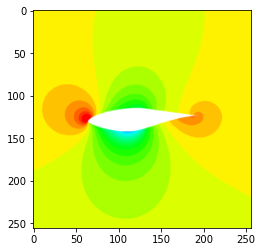

In [36]:
from PIL import Image
import matplotlib.pyplot as plt
Y_prediction = model.predict(X_test)

label = Y_test[53]
prediction = Y_prediction[53]
test_img= Image.fromarray((label*255).astype(np.uint8))
predi_img= Image.fromarray((prediction*255).astype(np.uint8))
plt.imshow(test_img)
print(Y_test[0].shape)
print(Y_prediction[0].shape)
# img_test_label = Image.fromarray(img_test_label)
# img_test_label.show()

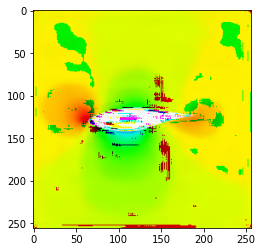

In [37]:
plt.imshow(predi_img)